# Intro to PINNs

These first two cells just setup the NN class and generates training data. No changes are necessary, and, in fact, this definition can be used as a starting point for lots of projects (stock market predictions, anyone..?)

In [1]:
import matplotlib.pyplot as plt

from tqdm.notebook import trange  # nice timer progress bars
import numpy as np
import scipy as sp

import torch  # the machine learning toolbox we'll use (comparable to TensorFlow and Keras)
import torch.nn as nn

## Let's define a "Fully Connected Network"

class FCN(nn.Module): # implements NN as a class, nn.Module is base class in Pytorch for NN methods from which our custom class inherits
    def __init__(self, N_LAYERS, activation=nn.Tanh()): # constructor: self is used inside __init__ to refer to self, w/ N_LAYERS specifying NN in, hidden, out layers, activation spefying activation function
        super().__init__() # calls constructor of parent class from child class and initializes inherited attributs
        assert len(N_LAYERS) >= 3, "must be at least one hidden layer." # assert checks condition true and aborts if not

        layers = [] # initialize python layers list

# N_LAYERS is list of layers, slicing [:-1], [1:-1] makes sublists with in/out layers removed, zip pairs of matching elements from sublists as first, second
        for first, second in zip(N_LAYERS[:-1], N_LAYERS[1:-1]):  # just defining the layer structure
            layers.append(nn.Linear(first, second))  # configure NN connections, linear layer is a dot product plus bias
            layers.append(activation)  # configure NN connections, activation is our nonlinear function, usually tanh or sigmoid

        layers.append(nn.Linear(*N_LAYERS[-2:])) # select last two layers, asterisk * unpacks  list/tuple into arguments for nn.Linear constructor.
        self.seq = nn.Sequential(*layers) # creates layer sequence "self.seq" representing entire NN by unpacking layers

    def forward(self, x): # defines forward pass of NN in PyTorch, i.e. how data passes thru layers
        return self.seq(x) # x is input data that is passed thru NN represented by  self.seq


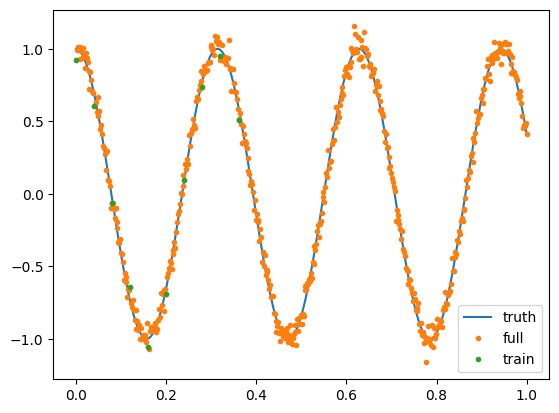

In [2]:
## GENERATE A TRAINING DATA SET
## generate some sample data from a damped harmonic oscillator
def osc(d, w0, x, nsr=0): # defines data points of underdampe HO, w0 nat freq, w, damped freq, d, damping constant,
    assert d < w0 # check underdamped
    w = np.sqrt(w0**2 - d**2) # calculate damped osc freq
    phi = np.arctan(-d/w) # calc ampl, phase of damped HO
    A = (2*np.cos(phi))**-1 # calc ampl, phase of damped HO
    err = nsr * np.random.normal(0, 1, size=x.shape) # add noise
    return 2*A * torch.exp(-d*x) * torch.cos(w*x + phi) + err

## SHO parameters
d = 0
w0 = 20
mu = 2*d
k = w0**2
nsr = 0.05  # noise-to-signal ratio, set to 0 for perfect measurements

## Generate the SHO data, .view(-1, 1) operation reshapes the tensor for Pytorch
x = torch.linspace(0, 1, 500).view(-1, 1) # the view method just puts it in a column vector
y_truth = osc(d, w0, x).view(-1, 1) # a truth array for plotting (noise argument not given)
y = osc(d, w0, x, nsr=nsr).view(-1, 1) # the truth array plus some small amount of random noise (noise argument is given)

x_data = x[0:200:20]  # we are only going to train ob limited subset, 10 data points from first osciallation
y_data = y[0:200:20]

plt.plot(x, y_truth, label='truth')
plt.plot(x, y, '.', label='full')
plt.plot(x_data, y_data, '.', label='train')
plt.legend()


## Simple NN

With a very simple network, we only have a few hyper-parameters we can (should) play with:

1. Layers, the actual internal structure of the NN. Larger networks can model more complicated functions, but take longer to train. The goal is to use the simplest model that can model the solution.

2. Learning rate, the step size through loss space. High learning rates will train more quickly, but can't settle as well into local minima. More advanced networks use a "learning rate scheduler" to start with a high learning rate to quickly find the desired minimum, then reduces the learning rate to find the true minimum.

3. Epochs, the amount of time we train.

Other things that we can touch, but probably shouldn't:

1. The activation function, just used to introduce nonlinearity. Tanh is nice because its continuously differentiable.

2. The optimizer, ADAM is fine. This is the playground of comp sci people.

3. The loss function, there's no reason we have to use a mean squared error, but it's a nice analogy to Chi-squared.

  0%|          | 0/5000 [00:00<?, ?it/s]

FCN(
  (seq): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


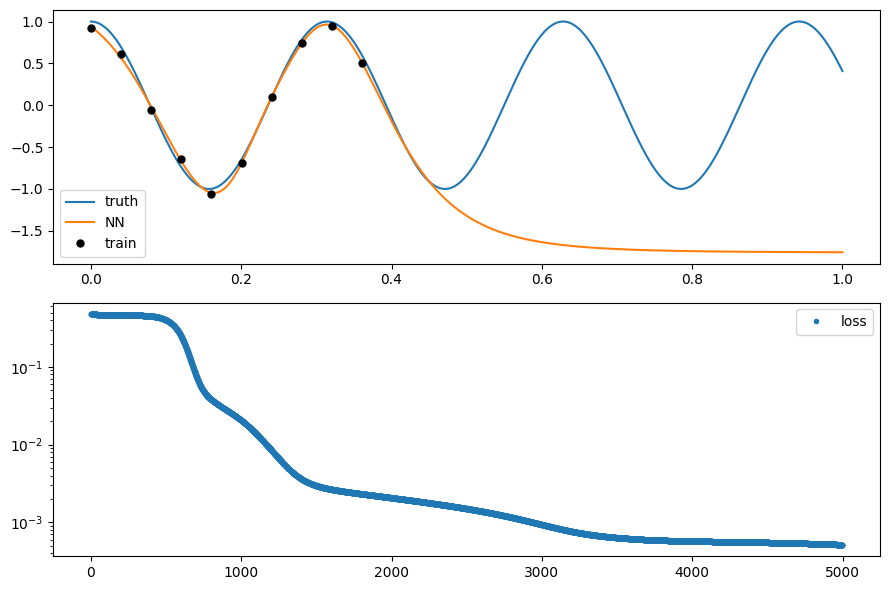

In [3]:
## Lets train a very simple model on the training data

##============================================================================##
## PLAY WITH THESE HYPER PARAMETERS!
## Training parameters
layers = [1, 8, 8, 1]  # try playing with both the number of hidden layers, and the number of features per hidden layer
lr = 1e-3  # learing rate, sets step size through loss space, try making it both larger and smaller
epochs = 5000  # we should train until the loss functions stop reducing
##============================================================================##

## do the training
model = FCN(layers)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
losses1 = []  # we're going to save the loss from each epoch
for i in trange(epochs):
    optimizer.zero_grad()  # reset the gradient graph on each epoch
    yh = model(x_data)  # yh stands for y hat, "hat" meaning NN prediction of the value y
    loss = torch.mean((yh-y_data)**2)  # simple mean squared error loss
    losses1.append(loss.detach().numpy())  # safe our loss values for plotting
    loss.backward()  # calculate gradients
    optimizer.step()  # apply to the NN parameters

## Now that the network is trained, plot it

y_nn = model(x).detach().numpy()  # the detach method drops the requirements to track gradients

print(model)

fig1, ax1 = plt.subplots(2)

ax1[0].plot(x, y_truth, label='truth')
ax1[0].plot(x, y_nn, label='NN')
ax1[0].plot(x_data, y_data, '.', ms=10, color='black', label='train')
ax1[0].legend()

ax1[1].semilogy(losses1, '.', label='loss')
ax1[1].legend()

fig1.set_size_inches(9,6)
fig1.tight_layout()


## PINN

Now let's introduce the laws of physics. We are going to directly include the differential equation $(\partial_{t^2} + \mu \partial_t + k)~y(t) = 0$ as an additional loss term, called the "physics loss".

In addition to the hyper-parameters discussed before, the PINN has a couple more important parameters for us:

1. Physics loss locations, the places we are evaluating the EoM and pressuring it towards 0. Too many locations drastically slows training. Not enough won't apply enough pressure to shape the solution properly.

2. The physics loss coefficient, sets the relative importance of the measurement loss and physics loss. Too low and the NN would rather exactly fit the data points than satisfy the PDQ. Too high, and the NN will discover $y=0$ is a good solution for the physics loss portion before it finds the measurements.

  0%|          | 0/30000 [00:00<?, ?it/s]

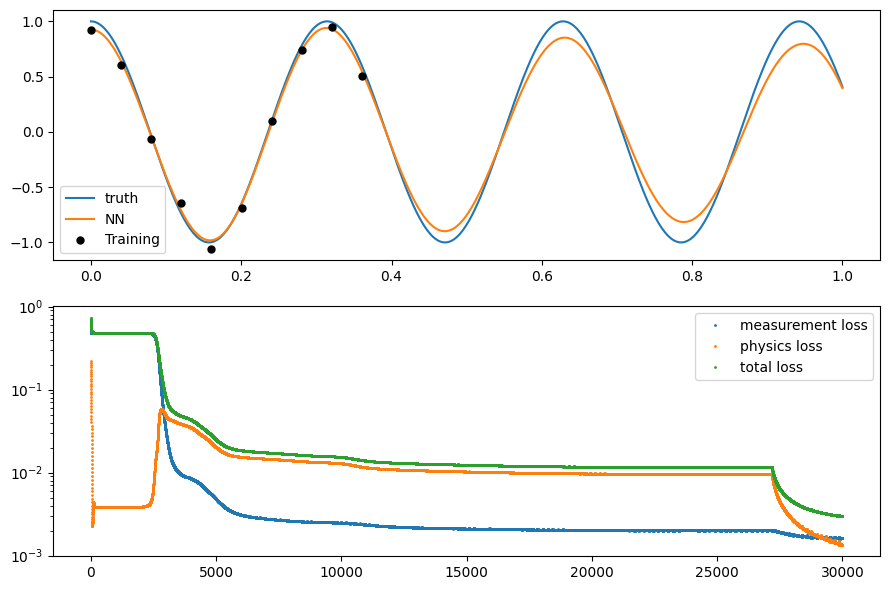

In [4]:
## Let's teach our NN some physics

##============================================================================##
## PLAY WITH THESE HYPER PARAMETERS!
## Training parameters
layers = [1, 8, 8, 1]
lr = 1e-3
epochs = 30000  # takes longer to train with more complicated loss

x_physics = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)  # 30 "physics loss locations"
phys_ratio = 1e-5  # sets the relative importance of the physics loss to the measurement loss
##============================================================================##

model2 = FCN(layers)  # We can use the same fully connected network! We'll just train a new one.
optimizer = torch.optim.Adam(model2.parameters(),lr=lr)
losses2 = []
losses2_m = []
losses2_p = []
for i in trange(epochs):
    optimizer.zero_grad()
    yh = model2(x_data)
    loss1 = torch.mean((yh-y_data)**2)  # simple MSE loss again
    losses2_m.append(loss1.detach().numpy())  # save MSE loss to plot

    ## We can use the built in "autograd" to take derivatives!
    yhp = model2(x_physics)  # evaluate our model at the physics loss locations
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  # dy/dx
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]  # d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp  # EoM for a damped SHO
    loss2 = torch.mean(physics**2) * phys_ratio
    losses2_p.append(loss2.detach().numpy())

    loss = loss1 + loss2
    losses2.append(loss.detach().numpy())

    loss.backward()
    optimizer.step()

y_nn = model2(x).detach().numpy()  # the detach method drops the requirements to track gradients
fig2, ax2 = plt.subplots(2)

ax2[0].plot(x, y_truth, label='truth')
ax2[0].plot(x, y_nn, label='NN')
ax2[0].plot(x_data, y_data, '.', ms=10, color='black', label='Training')
ax2[0].legend()

ax2[1].semilogy(losses2_m, '.', label='measurement loss', ms=2)
ax2[1].semilogy(losses2_p, '.', label='physics loss', ms=2)
ax2[1].semilogy(losses2, '.', label='total loss', ms=2)
ax2[1].legend()

fig2.set_size_inches(9,6)
fig2.tight_layout()


## Pre-training

We can change the loss function in the middle of the training. This is useful for "pretraining" on just measurements, before adding the physics loss. This is both quicker than trying to simultaneously train both, and doesn't have the problem of finding trivial solutions like $y = 0$.

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

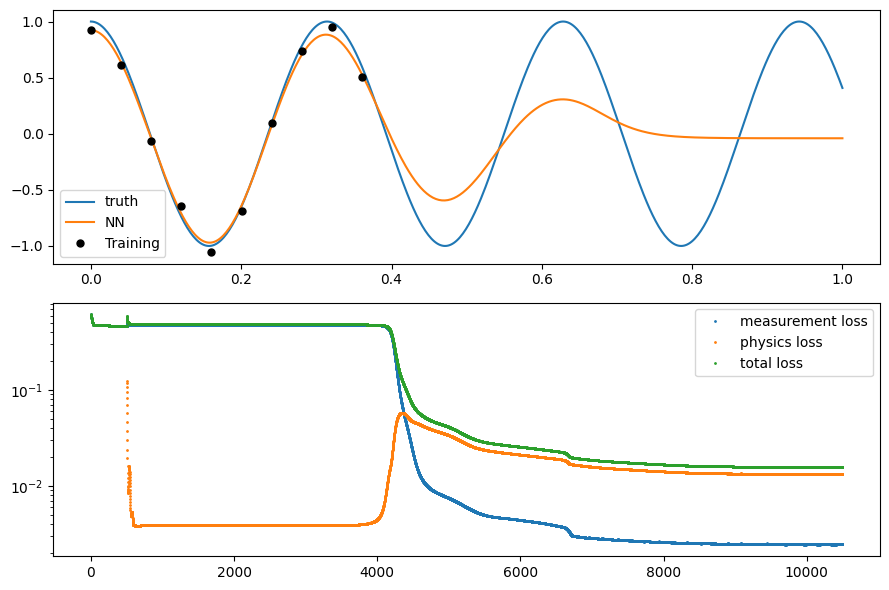

In [5]:
##============================================================================##
## PLAY WITH THESE HYPER PARAMETERS!
## Training parameters
layers = [1, 8, 8, 1]
lr = 1e-3
epochs1 = 500
epochs2 = 10000

x_physics = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)
phys_ratio = 1e-5
##============================================================================##

model3 = FCN(layers)
optimizer = torch.optim.Adam(model3.parameters(),lr=lr)
losses3 = []
losses3_m = []
losses3_p = []
##pre-train on just MSE loss
for i in trange(epochs1):
    optimizer.zero_grad()
    yh = model3(x_data)
    loss = torch.mean((yh-y_data)**2)
    losses3.append(loss.detach().numpy())
    losses3_m.append(loss.detach().numpy())
    losses3_p.append(np.nan)
    loss.backward()
    optimizer.step()
## continue training with PINN
for i in trange(epochs2):
    optimizer.zero_grad()
    yh = model3(x_data)
    loss1 = torch.mean((yh-y_data)**2)
    losses3_m.append(loss1.detach().numpy())

    yhp = model3(x_physics)
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  # dy/dx
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]  # d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp
    loss2 = torch.mean(physics**2) * phys_ratio
    losses3_p.append(loss2.detach().numpy())

    loss = loss1 + loss2
    losses3.append(loss.detach().numpy())

    loss.backward()
    optimizer.step()

y_nn = model3(x).detach().numpy()  # the detach method drops the requirements to track gradients
fig3, ax3 = plt.subplots(2)

ax3[0].plot(x, y_truth, label='truth')
ax3[0].plot(x, y_nn, label='NN')
ax3[0].plot(x_data, y_data, '.', ms=10, color='black', label='Training')
ax3[0].legend()

ax3[1].semilogy(losses3_m, '.', label='measurement loss', ms=2)
ax3[1].semilogy(losses3_p, '.', label='physics loss', ms=2)
ax3[1].semilogy(losses3, '.', label='total loss', ms=2)
ax3[1].legend()

fig3.set_size_inches(9,6)
fig3.tight_layout()
